# ICR - Identifying Age-Related Conditions Dataset with TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the ICR - Identifying Age-Related Conditions dataset made available for this competition. The goal of the model is to predict if a person has one or more of any of three medical conditions or none.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the libraries

In [1]:
#import tensorflow as tf
#import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
from sklearn import linear_model

from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


In [2]:
#print("TensorFlow v" + tf.__version__)
#print("TensorFlow Decision Forests v" + tfdf.__version__)

# Load the Dataset

In [3]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
print(f"Full train dataset shape is {dataset_df.shape}")

Full train dataset shape is (617, 58)


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [4]:
dataset_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

# Quick basic dataset exploration

In [5]:
#dataset_df.info()

## Pie chart for label column: Class

<Axes: ylabel='Class'>

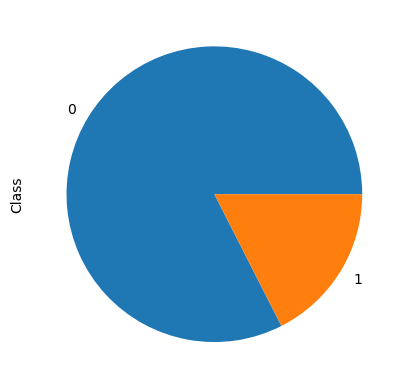

In [6]:
plot_df = dataset_df.Class.value_counts()
plot_df.plot(kind="pie")

**Important**: From the pie chart we can see that the dataset is heavily imbalanced since the fraction of positive(`1`) samples is very small compared to the negative(`0`) samples.

Dataset is imbalanced ! let's solve this 

Class Weighting 

In [7]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(dataset_df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = total / (neg * 2.0)
weight_for_1 = total / (pos *  2.0) 

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


========== data splitting ============

In [8]:
dataset_df.isna().mean().mean()

0.0036606494159727265

There are some NA's in dataset. Let's impute it. 

In [9]:
# select numeric data
X = dataset_df.select_dtypes(exclude=object).drop("Class",axis = 1)

What is the proportion of NAs in datatset ?

In [10]:
### proportion NA's
print(f"The proportion of NAs is : {X.isna().mean().mean().round(3)}\n")

The proportion of NAs is : 0.004



In [11]:
# impute dataset
#import numpy as np
import numpy as np
#from sklearn.impute import KNNImputer
#imputer = KNNImputer(n_neighbors=5)
for var in X.columns :
    if X[var].isna().mean() > 0 :
        X[X[var].isna()] = X[var].median()
   

In [12]:
# check proportion of NA's
print(f"The proportion of NAs is : {X.isna().mean().mean()}\n")

The proportion of NAs is : 0.0



In [13]:
# replace imputed columns in original dataset 
dataset_df[X.columns.to_list()] = X

In [14]:
# head dataset 
dataset_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [15]:
from sklearn.model_selection import train_test_split
y = dataset_df["Class"]
train0, test = train_test_split(dataset_df,test_size = 0.2,
                                stratify=dataset_df.Class, random_state=42)
train, valid = train_test_split(train0,test_size = 0.2,
                                stratify=train0.Class, random_state=42)

=========== model testing =========

=== Logistic regression === 

In [16]:
#### logistic regresion
num_var = [var for var in dataset_df.columns if var not in ["Id","EJ","Class"]]
X_train = train0[num_var]
y_train0 = y[X_train.index]

# scale X 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train) # scaler
X_train_scaled = scaler.transform(X_train)

In [17]:
# logistic regression 
from sklearn.linear_model import LogisticRegression
regClf = LogisticRegression(random_state=42,
                             class_weight ='balanced',
                             multi_class = 'auto',
                             max_iter= 1000)
regClfModel = regClf.fit(X_train_scaled, y_train0)
 

In [18]:
# ridge 
from sklearn.linear_model import RidgeClassifier
ridgeClf = RidgeClassifier(alpha = 0.1,
                                random_state=42,
                               class_weight ='balanced',
                           max_iter= 1000
                                ).fit(X_train_scaled,
                                 y_train0,
                                )


In [19]:
# ridgeCV
from sklearn import linear_model
ridgeCV = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13),cv = 5)

In [20]:
from sklearn.ensemble import RandomForestClassifier
Rf = RandomForestClassifier(n_estimators=10)

In [21]:
DTclf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
     random_state=0)
#scores = cross_val_score(clf, X, y, cv=5)
#scores.mean()


In [22]:
# extra tree classifier 
XTclf = ExtraTreesClassifier(n_estimators=10, max_depth=None,
     min_samples_split=2, random_state=0)
 #scores = cross_val_score(clf, X, y, cv=5)


In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                             max_samples=0.5, max_features=0.5)

In [24]:
from sklearn.ensemble import AdaBoostClassifier

adaClf = AdaBoostClassifier(n_estimators=100)

In [25]:
# gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

gbclf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)

In [26]:
# Histogram based Gradient Boosting Classifier
from sklearn.ensemble import HistGradientBoostingClassifier

hbGbclf = HistGradientBoostingClassifier(max_iter=100)


In [27]:
# model dictionary
model_dict = {"regClf": regClf,
              "ridge": ridgeClf,
              "ridgeCV": ridgeCV,
    # average meodels 
              "Rf": Rf,
              "DTclf": DTclf,
              "XTclf": XTclf,
              "bagCl": bagging,
    # boosting models 
             "adaClf": adaClf,
            "gbCl": gbclf ,
            "hbGbclf" : hbGbclf
    # voting classifier
    # stacked (generalization ) classifier
        }

In [28]:
# function to run models 
def runModel(model_dict,train_data,y_train):
    scores = {}
    for model in model_dict :
        model0 =model_dict[model].fit(train_data,y_train)
        perf0 = cross_val_score(model0,train_data,y_train,cv= 5).mean()
        scores[model] = perf0
        print(model)
    perf_df = (pd.DataFrame(data = scores.values(), index = scores.keys(), columns = ["perf"])
        .sort_values(by="perf",ascending = False)
        )
    print("\n")
    return perf_df.iloc[:1,0]


In [29]:
perf = runModel(model_dict=model_dict,train_data = X_train,y_train = y_train0)
perf

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

regClf
ridge
ridgeCV
Rf
DTclf
XTclf
bagCl
adaClf
gbCl
hbGbclf




hbGbclf    0.931107
Name: perf, dtype: float64

In [30]:
#valid score
# fit model 
hbGbclf.fit(X_train,y_train0)

# predict
pred_val = hbGbclf.predict_proba(valid[num_var])
pred_val2 = hbGbclf.predict(valid[num_var])
print(f'valid score: {hbGbclf.score(valid[num_var],valid["Class"]).round(2)*100} %\n')

valid score: 99.0 %



In [31]:
from sklearn.metrics import classification_report

y_true = valid['Class']
y_pred = pred_val2
target_names = ['class_0', 'class_1']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class_0       0.99      1.00      0.99        82
     class_1       1.00      0.94      0.97        17

    accuracy                           0.99        99
   macro avg       0.99      0.97      0.98        99
weighted avg       0.99      0.99      0.99        99



Let us now plot the first 6 numerical columns and their values using bar charts.

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[82,  0],
       [ 1, 16]])

# Submission

In [33]:
# read test dataframe and predict 
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
predictions = hbGbclf.predict_proba(test_df.select_dtypes(exclude=object))

predictions = pd.DataFrame(predictions)

# add test Id
predictions['Id'] = test_df['Id']
predictions['class_0'] = predictions.iloc[:,0]
predictions['class_1'] = predictions.iloc[:,1]
predictions = predictions[['Id','class_0','class_1']]

In [34]:
# write csv 
predictions.to_csv("submission.csv", index = None)
pd.read_csv("/kaggle/working/submission.csv")

,Id,class_0,class_1
0,00eed32682bb,0.030582,0.969418
1,010ebe33f668,0.030582,0.969418
2,02fa521e1838,0.030582,0.969418
3,040e15f562a2,0.030582,0.969418
4,046e85c7cc7f,0.030582,0.969418


In [35]:
#sample_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
#sample_submission[['class_0', 'class_1']] = predictions[['class_0', 'class_1']]
#sample_submission.to_csv('/kaggle/working/submission.csv', index=False)
#pd.read_csv("/kaggle/working/submission.csv")